## Statisitically Testing 2P Responses to Stimulus

### Environment Setup

In [1]:
### if running on Google Colab, run this cell once, then restart the runtime and run the rest of the notebook
import os
if "COLAB_GPU" in os.environ:
    !wget https://raw.githubusercontent.com/AllenInstitute/openscope_databook/main/requirements.txt
    %pip install -r requirements.txt --user

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from dandi import dandiapi
from pynwb import NWBHDF5IO
from scipy import interpolate

%matplotlib inline

### Downloading Ophys File
Change the values below to download the file you’re interested in. Set `dandiset_id` and `dandi_filepath` to correspond to the dandiset id and filepath of the file you want. If you’re accessing an embargoed dataset, change `authenticate` to True, and set `dandi_api_key` to your DANDI API key. If you want to stream a file instead of downloading it, checkout Streaming an NWB File with fsspec.

In [3]:
dandiset_id = "000336"
dandi_filepath = "sub_1170622509/sub_1170622509sess_1194683535/sub_1170622509+sess_1194683535+exp_1194752582_ophys.nwb"
authenticate = True
dandi_api_key = os.environ["DANDI_API_KEY"]
download_loc = "."

In [4]:
filename = dandi_filepath.split("/")[-1]
filepath = f"{download_loc}/{filename}"

In [5]:
if authenticate:
    client = dandiapi.DandiAPIClient(token=dandi_api_key)
else:
    client = dandiapi.DandiAPIClient()
my_dandiset = client.get_dandiset(dandiset_id)
print(f"Got dandiset {my_dandiset}")

A newer version (0.54.0) of dandi/dandi-cli is available. You are using 0.46.6


Got dandiset DANDI:000336/draft


In [6]:
# file = my_dandiset.get_asset_by_path(dandi_filepath)
# # this may take awhile, especially if the file to download is large
# file.download(filepath)

# print(f"Downloaded file to {filepath}")

### Getting 2P Data and Stimulus Data
Below, the fluorescence traces and timestamps are read from the file's `Processing` section. Note that the exact format to access these traces can vary between newer and older NWB files, so some adjustments may be necessary. Additionally, the stimulus data is also read from the NWB file's `Intervals` section. Stimulus information is stored as a series of tables depending on the type of stimulus shown in the session. One such table is displayed below, as well as the names of all the tables.

In [7]:
io = NWBHDF5IO(filepath, mode="r", load_namespaces=True)
nwb = io.read() 

c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.3.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [8]:
dff = nwb.processing["ophys"]["dff"]
dff_trace = dff.roi_response_series["traces"].data
dff_timestamps = dff.roi_response_series["traces"].timestamps

flr = nwb.processing["ophys"]["corrected_fluorescence"]
flr_trace = flr.roi_response_series["traces"].data
flr_timestamps = flr.roi_response_series["traces"].timestamps

# accessing the above data may look different for older nwb files, like the following
# dff_trace = dff.roi_response_series["RoiResponseSeries"].data
# dff_timestamps = dff.roi_response_series["RoiResponseSeries"].timestamps

print(flr_trace.shape)
print(flr_timestamps.shape)
print(dff_trace.shape)
print(dff_timestamps.shape)

(42337, 103)
(42337,)
(42337, 103)
(42337,)


### Selecting Stimulus Times

In [9]:
stimulus_names = list(nwb.intervals.keys())
print(stimulus_names)

['fixed_gabors_presentations', 'gratings_presentations', 'movie_flower_fwd_presentations', 'movie_touch_of_evil_fwd_presentations', 'movie_worms_fwd_presentations', 'rotate_gabors_presentations', 'spontaneous_presentations']


In [131]:
stim_table = nwb.intervals['fixed_gabors_presentations']
print(stim_table.colnames)
stim_table[:10]

('start_time', 'stop_time', 'stimulus_name', 'stimulus_block', 'units', 'stimulus_index', 'OriSurp', 'PosSizesAll', 'colors', 'contrs', 'depths', 'elementMask', 'elementTex', 'fieldDepth', 'fieldPos', 'fieldShape', 'fieldSize', 'nElements', 'opacities', 'oris', 'phases', 'rgbs', 'sfs', 'sizes', 'xys', 'tags', 'timeseries')


,start_time,stop_time,stimulus_name,stimulus_block,units,stimulus_index,OriSurp,PosSizesAll,colors,contrs,...,nElements,opacities,oris,phases,rgbs,sfs,sizes,xys,tags,timeseries
id,,,,,,,,,,,,,,,,,,,,,
0,2792.313550,2792.613804,fixed_gabors,182.0,pix,5.0,"(300, 0)",0.0,"[1.0, 1.0, 1.0]",ndarray(...),...,45.0,ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),[stimulus_time_interval],"[(166459, 18, timestamps pynwb.base.TimeSeries..."
1,2792.613804,2792.914058,fixed_gabors,182.0,pix,5.0,"(300, 0)",1.0,"[1.0, 1.0, 1.0]",ndarray(...),...,45.0,ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),[stimulus_time_interval],"[(166477, 18, timestamps pynwb.base.TimeSeries..."
2,2792.914058,2793.214312,fixed_gabors,182.0,pix,5.0,"(300, 0)",2.0,"[1.0, 1.0, 1.0]",ndarray(...),...,45.0,ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),[stimulus_time_interval],"[(166495, 18, timestamps pynwb.base.TimeSeries..."
3,2793.214312,2793.514562,fixed_gabors,182.0,pix,5.0,"(300, 0)",3.0,"[1.0, 1.0, 1.0]",ndarray(...),...,45.0,ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),[stimulus_time_interval],"[(166513, 18, timestamps pynwb.base.TimeSeries..."
4,2793.514562,2793.814809,fixed_gabors,182.0,pix,5.0,N/A,NaN,"[1.0, 1.0, 1.0]",ndarray(...),...,45.0,ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),[stimulus_time_interval],"[(166531, 18, timestamps pynwb.base.TimeSeries..."
5,2793.814809,2794.115055,fixed_gabors,182.0,pix,5.0,"(90, 0)",0.0,"[1.0, 1.0, 1.0]",ndarray(...),...,45.0,ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),[stimulus_time_interval],"[(166549, 18, timestamps pynwb.base.TimeSeries..."
6,2794.115055,2794.415305,fixed_gabors,182.0,pix,5.0,"(90, 0)",1.0,"[1.0, 1.0, 1.0]",ndarray(...),...,45.0,ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),[stimulus_time_interval],"[(166567, 18, timestamps pynwb.base.TimeSeries..."
7,2794.415305,2794.715559,fixed_gabors,182.0,pix,5.0,"(90, 0)",2.0,"[1.0, 1.0, 1.0]",ndarray(...),...,45.0,ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),[stimulus_time_interval],"[(166585, 18, timestamps pynwb.base.TimeSeries..."
8,2794.715559,2795.015813,fixed_gabors,182.0,pix,5.0,"(90, 0)",3.0,"[1.0, 1.0, 1.0]",ndarray(...),...,45.0,ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),ndarray(...),[stimulus_time_interval],"[(166603, 18, timestamps pynwb.base.TimeSeries..."


In [166]:
diff = np.mean(np.diff(stim_table.start_time))
diff

0.30024879397672677

In [132]:
### select start times from table that fit certain critera here

# stim_select = lambda row: True
stim_select = lambda row: float(row.stimulus_index) == 5.0
all_stim_times = [float(stim_table[i].start_time) for i in range(len(stim_table)) if stim_select(stim_table[i])]
len(all_stim_times)

1500

### Fluorescence Interpolation

In [133]:
interp_hz = 10

In [134]:
print(flr_trace.shape)
print(flr_timestamps.shape)

(42337, 103)
(42337,)


In [135]:
# generate regularly-space x values and interpolate along it
time_axis = np.arange(flr_timestamps[0], flr_timestamps[-1], step=(1/interp_hz))
interp_flr = []

# interpolate channel by channel to save RAM
for channel in range(flr_trace.shape[1]):
    f = interpolate.interp1d(flr_timestamps, flr_trace[:,channel], axis=0, kind="nearest", fill_value="extrapolate")
    interp_flr.append(f(time_axis))

interp_flr = np.array(interp_flr)

print(interp_flr.shape)

(103, 39415)


In [167]:
rate = ((flr_timestamps[-1] - flr_timestamps[0]) / len(flr_timestamps))
print(rate)

0.09309768075206085


In [168]:
rate / diff

0.31006845862394083

In [136]:
interp_flr.shape

(103, 39415)

### Getting Stimulus Time Windows

In [172]:
window_start_time = -0.5
window_end_time = 2

In [173]:
# validate window bounds
if window_start_time > 0:
    raise ValueError("start time must be non-positive number")
if window_end_time <= 0:
    raise ValueError("end time must be positive number")
    
# get event windows
windows = []
window_length = int((window_end_time-window_start_time) * interp_hz)

for stim_ts in all_stim_times:
    # convert time to index
    start_idx = int( (stim_ts + window_start_time - flr_timestamps[0]) * interp_hz )
    end_idx = start_idx + window_length
 
    # bounds checking
    if start_idx < 0 or end_idx > interp_flr.shape[1]:
        continue
        
    windows.append(interp_flr[:,start_idx:end_idx])
    
if len(windows) == 0:
    raise ValueError("There are no windows for these timestamps")

windows = np.array(windows)
print(windows.shape)

(1500, 103, 25)


### Aligning Time Windows

 ...]

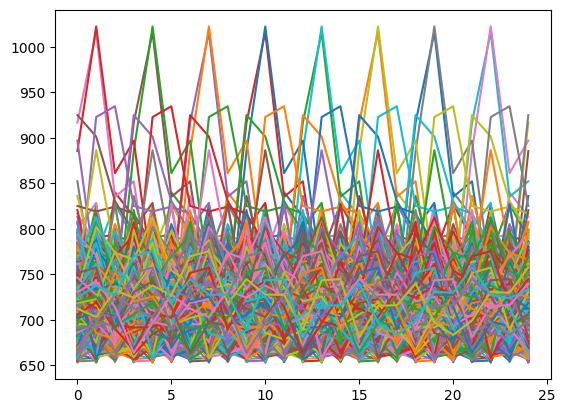

In [174]:
plt.plot(windows[:,1].transpose())

(103, 25)


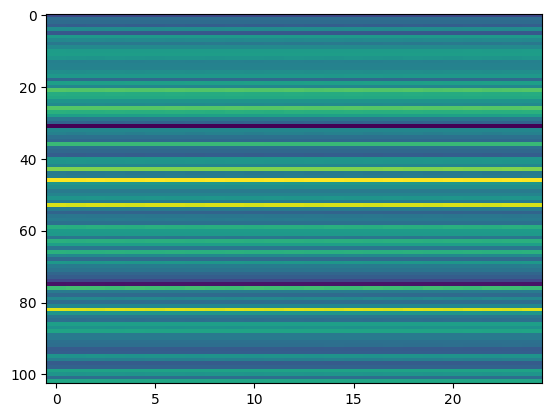

In [161]:
mean_window = np.mean(windows, axis=0)
print(mean_window.shape)
plt.imshow(mean_window, aspect="auto")